# Tutorial 5 (Week 6) - Linear Regression

## Learning Objectives

After completing this tutorial, you should be able to:

+ Use `statsmodels` to perform linear regression
+ Implement Simple Linear Regression
+ Estimate coefficients and analyze the model
+ Apply the model for hypothesis testing
+ Implement Multiple Linear Regression

This tutorial uses the case study covered in the textbook "An Introduction to Statistical Learning: with Applications in R" by James G. et al. ([link](https://link-springer-com.libproxy1.nus.edu.sg/book/10.1007/978-1-4614-7138-7)). The codes are written using this [notebook](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb) and this [notebook](https://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%203.ipynb).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#plt.style.use('seaborn-v0_8-white')

## Dataset

The Advertising data set consists of the _sales_ (in thousands on units) of a certain product in 200 different markets, along with _advertising budgets_ (in thousands of dollars) for the product in each of those markets for three different media: TV, radio, and newspaper. 

Suppose you are a data analyst hired to provide advice on how to improve sales of this product.

It is not possible for your client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if you determine that there is an association between advertising and sales, then you can instruct your client to adjust advertising budgets, thereby indirectly increasing sales.
In other words, your goal is to develop an __accurate model that can be used to predict sales on the basis of the three media budgets__.

As usual, load the data into pandas, and obtain a summary statistics to start exploring. You can specify `index_col` to treat the first column as index values.

In [4]:
# TODO
advertising = pd.read_csv( 'Advertising-T5.csv', index_col=0 )
advertising.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


# Introduction to Statsmodels

As the name implies, `statsmodels` is a Python library built specifically for statistics. It is built on top of NumPy, SciPy, and matplotlib, but it contains more advanced functions for statistical testing and modeling that you won't find in numerical libraries like NumPy or SciPy. To know more about this package, follow the tutorials in this [link](https://www.statsmodels.org/stable/user-guide.html).

The `statsmodels` package is included in the Anaconda distribution.

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

`statsmodels` allows users to fit statistical models using R-style formulas. The `formula.api` module is a convenience interface for specifying models using formula strings and DataFrames. It hosts lowercase counterparts for many of the same functions found in the `api` module (e.g., `ols` corresponding to `api.OLS`, `glm` corresponding to `api.GLM`). In general, the lowercase models accept `formula` and `df` arguments, whereas uppercase ones take [`endog` and `exog`](https://www.statsmodels.org/stable/endog_exog.html) design matrices.

## Simple Linear Regression

Simple Linear Regression (SLR) predicts a response _Y_ on the basis of a single predictor variable _X_. It assumes an approximately linear relationship between _X_ and _Y_. 

We can regress sales (Y) onto TV (X) by fitting the model:
$sales \approx \beta_{0} + \beta_{1} \times TV$

$\beta_{0}$ (_intercept_) and $\beta_{1}$ (_coefficient of X_) are the model coefficients. We must estimate their values, using our data, to be able to make predictions with the model.
 
Let us first plot the regression of sales onto TV, using seaborn `regplot`.

(0.0, 311.185)

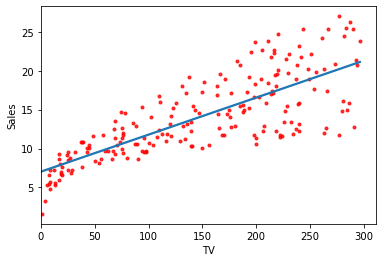

In [6]:
# TODO
sns.regplot( x=advertising.TV, y=advertising.Sales, ci=None, scatter_kws={'color':'r', 's':9}  )

# Start the x-axis at 0 to make the intercept clear
plt.xlim( xmin=0 )

We will use the _least squares_ method to estimate the coefficients. We look at two ways to perform the regression, one using the uppercase model `OLS` from `api` and the other using the lowercase model `ols` from `formula.api`.

### `api.OLS`

The required inputs to [`OLS`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) are `endog` (the response y) and `exog` (the predictor x). 

An intercept is not included in `exog` by default and should be added by users. This is achieved by calling `statsmodels` function `add_constant`, which adds a column of ones to the `exog` array.

In [7]:
X = advertising[['TV']]
y = advertising[['Sales']]

est = sm.OLS( y, sm.add_constant(X) ).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.47e-42
Time:                        15:08:22   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### `formula.api.ols`

The required inputs to [`ols`](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) are the formula string and the data. The formula syntax follows the framework of the [`patsy`](https://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language) package.

In [8]:
est = smf.ols( formula='Sales ~ TV', data=advertising ).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.47e-42
Time:                        15:08:25   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the results obtained above, we can see the coefficient estimates as follows:
+ $\hat{\beta_{0}} = 7.03$
+ $\hat{\beta_{1}} = 0.0475$

In other words, an additional 1,000 dollars spent on TV advertising is associated with selling approximately 47.5 additional units of the product. This is because $\beta_{1}$ is the slope - the average increase in sales associated with a one-unit
increase in TV budget (which is in thousands of dollars).

In [9]:
est.params

Intercept    7.032594
TV           0.047537
dtype: float64

We can use the model coefficients to manually make a sales prediction. Suppose the company spends \$25,000 in a new market, how much sales can we predict that market will have? 

In [10]:
# TODO
est.params[0] + est.params[1] * 25

8.221009559953188

You can refer to the [`OLSResults` reference](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html) for other accessible attributes.

## Residuals and Assessing Model Accuracy

### Residual and RSS

__Residual__ ($e_{i} = y_{i}-\hat{y_{i}}$) is the difference between the $i^{th}$ observed response value and the $i^{th}$ response value that is predicted by our linear model. 

The least squares approach chooses the values for $\hat{\beta_{0}}$ and $\hat{\beta_{1}}$ to minimize the __residual sum of squares (RSS)__ ($ e^{2}_{1} + e^{2}_{2} + ...$).

We can use the model coefficients to manually calculate the RSS, by summing the squared residuals. Recall that the predicted value $\hat{y_{i}}$ is $\beta_{0} + \beta_{1} \times TV_{i}$.

In [11]:
# TODO
((advertising.Sales - (est.params[0] + est.params[1] * advertising.TV))**2).sum()

2102.5305831313512

We can check our calculation against the RSS value computed by OLS, which is given by the attribute `ssr` (sum of squared residuals) in the OLS result.

In [12]:
est.ssr

2102.5305831313512

### Residual Standard Error

The RSS value can be used to compute the residual standard error (RSE), which is given by the formula: $RSE = \sqrt{\frac{RSS}{n-2}}$ where $n$ is the number of samples.

In [13]:
# TODO
np.sqrt( est.ssr / (len(advertising.TV) - 2) )

3.2586563686504624

The RSE is found to be 3.26. In other words, actual sales in each market deviate from the true regression line by approximately 3.26 units, on average.

The OLS results also show us the standard errors of the model coefficients, which are the standard deviation over these coefficients learned from the samples. They are shown in the summary and also accessible from the attribute `bse`.

In [15]:
# TODO
est.bse

Intercept    0.457843
TV           0.002691
dtype: float64

### Confidence Interval and Hypothesis Testing

We can call the function [`conf_int`](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.conf_int.html) from the OLS results to get the 95% confidence interval of the model coefficients.

In [16]:
# TODO
est.conf_int( alpha = .05 )

,0,1
Intercept,6.129719,7.935468
TV,0.042231,0.052843


As it relates to model coefficients, the conventional hypothesis test is as follows:

+ Null hypothesis: There is no relationship between TV ads and Sales (that is, $\beta_{1} = 0$)

+ Alternative hypothesis: There is a relationship between TV ads and Sales (that is, $\beta_{1} \neq 0$)

Intuitively, we reject the null hypothesis if the 95% confidence interval of $\beta_{1}$ does not include zero. We can check the p-value, the probability that the coefficient is actually zero, from the OLS results as well.

In [17]:
# TODO
est.pvalues

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

As the p-value for TV is less than 0.05, we reject the null hypothesis that there is no relationship between TV ads and Sales.

Note that the p-value for the intercept is generally not used.

### R-squared statistic
The $R^{2}$ statistic provides an alternative measure of fit. It takes the form of a proportion—the proportion of variance
explained—and so it always takes on a value between 0 and 1, and is independent of the scale of Y.

$ R^{2} = 1 - \frac{RSS}{TSS}$

The __Total Sum of Squares (TSS)__ measures the total variance in the response Y, and can be thought of as the amount of variability inherent in the response before the regression is performed. In contrast, RSS measures the amount of variability that is left unexplained after performing the regression. An $R^{2}$ statistic that is close to 1 indicates that a large proportion of the variability in the response has been explained by the regression.

The OLS result already provides us with the $R^{2}$ value, and we can access it from its attributes.

In [18]:
# TODO
est.rsquared

0.611875050850071

Now let us plot the residuals with respect to the predicted values.  

For this plot, we can use [`sns.residplot`](https://seaborn.pydata.org/generated/seaborn.residplot.html) which will regress y on x and then draw a scatterplot of the residuals. So the graph we will obtain will be a scatterplot for the residuals with the predictor variable.

We can set the `lowess` parameter to add a LOWESS (Locally Weighted Scatterplot Smoothing) curve, to help emphasize structure in the scatterplot.

<AxesSubplot:xlabel='TV', ylabel='Sales'>

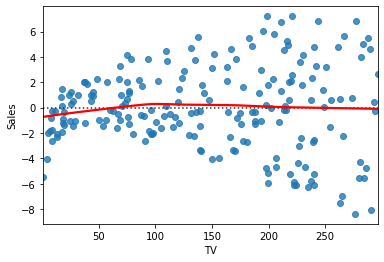

In [19]:
# TODO
sns.residplot( x=advertising['TV'], y=advertising['Sales'], lowess=True, order=1, line_kws=dict(color="r") )

 Ideally, this should look like a random scatter plot with zero mean and constant variance for all predicted values. Our residual plot doesn't look like an ideal residual plot. This is because the mean line of the residuals is not close to zero for all values of  $\hat{y}$ and the variance seems to be increasing with the predictor, TV. This means that our model assumptions are being violated.
 
Among many possible reasons for this violation, the following are usual suspects:
+ There is another feature other than TV that affects sales.
+ The relation between TV and sales is not linear. 

We will implement the first fix using Multiple Linear Regression. But first let's break the model linearity assumption.

## Polynomial Regression and Heteroscedasticity

As we see, the assumption of linearity between TV and sales might not hold. However, from the residual plot, we observe more clearly that the standard deviation of residual keeps on increasing as the magnitude of predicted response increases. This issue is called __heteroscedasticity__. 

To address this issue, we could transform our response variable y with functions such as $\sqrt y$, $\log(y)$ or represent a new variable, $TV^2$. 

To differentiate the arithmetic operators we want to perform on our variables (such as $TV^2$) from Patsy operators inside the formula, we can enclose the operation in Patsy's built-in identity function `I()`.

In [20]:
poly_est = smf.ols( 'np.log(Sales) ~ TV + I(TV**2)', data=advertising ).fit()
poly_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     201.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.60e-48
Time:                        15:24:18   Log-Likelihood:                 4.1605
No. Observations:                 200   AIC:                            -2.321
Df Residuals:                     197   BIC:                             7.574
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8039      0.049     37.091      0.000       1.708       1.900
TV             0.0082      0.001     10.431      0.000       0.007       0.010
I(TV ** 2) -1.515e-05   2.62e-06     -5.773      0.000   -2.03e-05   -9.98e-06
==============================================================================
Omnibus:                       54.051   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.339
Skew:                          -1.106   Prob(JB):                     9.24e-36
Kurtosis:                       6.804   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To see the values in the model:

In [21]:
smf.ols( 'np.log(Sales) ~ TV + I(TV**2)', data=advertising ).exog[:5,]

array([[1.000000e+00, 2.301000e+02, 5.294601e+04],
       [1.000000e+00, 4.450000e+01, 1.980250e+03],
       [1.000000e+00, 1.720000e+01, 2.958400e+02],
       [1.000000e+00, 1.515000e+02, 2.295225e+04],
       [1.000000e+00, 1.808000e+02, 3.268864e+04]])

Plotting the residuals, note that the order is 2.

<AxesSubplot:xlabel='TV', ylabel='Sales'>

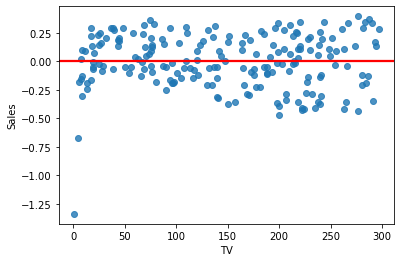

In [24]:
sns.residplot( x=advertising["TV"], y=np.log(advertising['Sales'] ), lowess=True, order=2, line_kws=dict(color="r") )

## Performing Model Prediction

In an earlier section, we manually calculated the sales prediction for a TV ad spending of \$25,000. We can use the multiple linear regression model we have estimated to do the prediction for us.

NOTE: The sklearn library also has implementation of linear regression which can be used for such prediction. The API is the same one you are already familiar with - the `fit`, `transform` and `fit_transform` methods for the `sklearn.linear_model.LinearRegression`.

In [25]:
# Construct a DataFrame, which is the format expected by the statsmodels interface 
X_test = pd.DataFrame( {'TV': [25]} )

est.predict( X_test )

0    8.22101
dtype: float64

Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated (which they usually are), R-squared and p-values are less reliable. R-squared will always increase as we add more features to the model, even if they are unrelated to the response. Thus, selecting the model with the highest R-squared is not a reliable approach for choosing the best linear model. There is an alternative to R-squared called _adjusted R-squared_ that penalizes model complexity (to control for overfitting).

In general, to select the best model to use for prediction, you might want to resort to the classical _cross validation_. This is easily possible using the `sklearn` API.

## Multiple Linear Regression

When we have more than one predictor variables, we use multiple linear regression. It essentially gives each predictor a separate slope coefficient in a single model. So, if we want to analyze whether radio ads and newspaper ads are also associated with sales, we can do a multiple linear regression as:

$sales \approx \beta_{0} + \beta_{1} \times TV + \beta_{2} \times radio + \beta_{3} \times newspaper$

Let us first do a simple linear regression using `ols` on these features independently.

In [26]:
# TODO: Regress sales onto radio
est = smf.ols( formula='Sales ~ Radio', data=advertising ).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [27]:
# TODO: Regress sales onto newspaper
est = smf.ols( formula='Sales ~ Newspaper', data=advertising ).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


From the simple linear regression, we can say that a 1,000-dollars increase in spending on radio advertising is associated with an average increase in sales by around 203 units, while the same increase in spending on newspaper advertising is associated with an average increase in sales by around 55 units.

Now let us use `ols` to create a model with all three features, that is, the union of (TV + radio + newspaper).

In [28]:
# TODO
mul_est = smf.ols( formula='Sales ~ TV + Radio + Newspaper', data=advertising ).fit()
mul_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.58e-96
Time:                        15:29:38   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We notice that the multiple regression coefficient estimates for TV and Radio are pretty similar to the simple linear regression coefficients. However, while the newspaper regression coefficient estimate in SLR was significantly non-zero, the coefficient estimate for newspaper in the multiple regression model is close to zero, and the corresponding p-value is no longer significant, with a value around 0.86.

Let us check the correlation matrix of the Advertising data.

In [ ]:
advertising.corr()

From the correlation matrix, we notice that the correlation between radio and newspaper is 0.35. This reveals a tendency to spend more on newspaper advertising in markets where more is spent on radio advertising. 

Now suppose that the multiple regression is correct and newspaper advertising has no direct impact on sales, but radio advertising does increase sales. Then in markets where we spend more on radio our sales will tend to be higher, and as our correlation matrix shows, we also tend to spend more on newspaper advertising in those same markets. Hence, in a simple linear regression which only examines sales versus newspaper, we will observe that higher values of newspaper tend to be associated with higher values of sales, *even though newspaper advertising does not actually affect sales*. So newspaper sales are a surrogate for radio advertising; newspaper gets “credit” for the effect of radio on sales.

### F-statistic

The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares. Its value will range from zero to an arbitrarily large number. In multiple linear regression, the null hypothesis we look at is if there is a relationship between the response and predictor.

+ $H_{0}: \beta_{1} = \beta_{2} = \beta_{3} = ... = 0$

We can assess the accuracy of the multiple regression model.

In [29]:
print( "RSE:", mul_est.resid.std() )
print( "R squared:", mul_est.rsquared )
print( "F-statistic:", mul_est.fvalue )
print( "F-test pvalue:", mul_est.f_pvalue )

RSE: 1.6727572743844112
R squared: 0.8972106381789522
F-statistic: 570.2707036590942
F-test pvalue: 1.575227256092437e-96


The large F-statistic suggests that *at least one of the advertising media must be related to sales* (at least one is non-zero). We see that the probability of the f-statistic is close to zero, so we have extremely strong evidence that at least one of the media is associated with increased sales.

Suppose our null hypothesis is that specific coefficients are zero. The t-statistic for each predictor provide information about whether each individual predictor is related to the response, after adjusting for the other
predictors.

### Residual Plots for the Multiple Linear Regression

Let us again plot the residual plots to visualize the trend in residuals as we did for simple linear regression. 

As the `residplot` function is not designed for multiple linear regression, but only for simple linear regression, we will write a helper function `get_vis_dataframe` to get predictions from the model to plot. 

We make use of the function [`wls_prediction_std`](https://www.adamsmith.haus/python/docs/statsmodels.graphics.regressionplots.wls_prediction_std) from `statsmodels` sandbox module, which takes the regression result object and provides the lower and upper values within which the prediction will lie with 95% confidence.

In [30]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

def get_vis_dataframe( est, X, y, ylabel='yobs', yhlabel='ypred' ):
    
    # Prepare the dataframe: copy the predictors
    rvis = X.copy()
    
    # Observed response and predicted response
    rvis[ylabel], rvis[yhlabel] = y, est.predict( X )
    
    # Residuals obtained from OLS
    rvis['resid'] = est.resid

    # Obtain lower und upper confidence bounds using wls_prediction_std (standard error is not used)
    std, upper, lower = wls_prediction_std( est )
    rvis['upper'], rvis['lower'] = upper, lower
  
    return rvis

Applying it on the three features:

In [31]:
X = advertising[["TV", "Radio", "Newspaper"]]
y = advertising[["Sales"]]

mulvis = get_vis_dataframe( mul_est, X, y )
mulvis.head()

,TV,Radio,Newspaper,yobs,ypred,resid,upper,lower
1,230.1,37.8,69.2,22.1,20.523974,1.576026,17.158283,23.889666
2,44.5,39.3,45.1,10.4,12.337855,-1.937855,8.981672,15.694038
3,17.2,45.9,69.3,9.3,12.307671,-3.007671,8.919038,15.696303
4,151.5,41.3,58.5,18.5,17.597830,0.902170,14.246273,20.949386
5,180.8,10.8,58.4,12.9,13.188672,-0.288672,9.825762,16.551582


Now using `residplot` to plot the residuals:

<AxesSubplot:xlabel='ypred', ylabel='resid'>

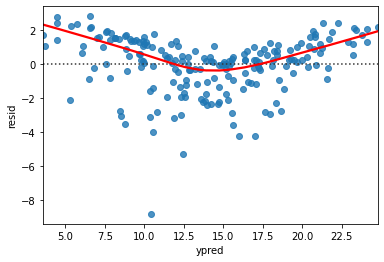

In [33]:
sns.residplot( x=mulvis["ypred"], y=mulvis.resid, lowess=True, order=1, line_kws=dict(color="r") )

### Multiple Polynomial Regression

Lastly, let us add polynomial terms to the multiple linear regression. We use a loop to construct the polynomial terms over the three features.

In [34]:
predictors = ["TV", "Radio", "Newspaper"]

poly2_predictors = []
for p in predictors:
    poly2_predictors.append( '{} + I({}**2)'.format(p, p) )

print( poly2_predictors )

['TV + I(TV**2)', 'Radio + I(Radio**2)', 'Newspaper + I(Newspaper**2)']


We can then construct the formula to pass to `ols`.

In [35]:
poly2_formula = 'Sales ~ '+ ' + '.join( poly2_predictors )
poly2_formula

'Sales ~ TV + I(TV**2) + Radio + I(Radio**2) + Newspaper + I(Newspaper**2)'

Now run `ols` with this formula.

In [36]:
# TODO
poly_mul_est = smf.ols( formula=poly2_formula, data=advertising ).fit()
poly_mul_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     358.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.01e-101
Time:                        15:34:45   Log-Likelihood:                -364.09
No. Observations:                 200   AIC:                             742.2
Df Residuals:                     193   BIC:                             765.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4111      0.457      3.085      0.002       0.509       2.313
TV                    0.0781      0.005     15.497      0.000       0.068       0.088
I(TV ** 2)           -0.0001    1.7e-05     -6.619      0.000      -0.000   -7.89e-05
Radio                 0.1595      0.028      5.611      0.000       0.103       0.216
I(Radio ** 2)         0.0007      0.001      1.219      0.224      -0.000       0.002
Newspaper             0.0101      0.015      0.693      0.489      -0.019       0.039
I(Newspaper ** 2)    -0.0001      0.000     -0.717      0.474      -0.000       0.000
==============================================================================
Omnibus:                       24.915   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.506
Skew:                          -0.592   Prob(JB):                     6.54e-12
Kurtosis:                       5.186   Cond. No.                     1.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can again use our `get_vis_dataframe` function and `residplot` to plot the residual plot of the multiple polynomial regression.

In [37]:
# TODO
mulvis = get_vis_dataframe( poly_mul_est, X, y )
mulvis.head()

,TV,Radio,Newspaper,yobs,ypred,resid,upper,lower
1,230.1,37.8,69.2,22.1,20.577400,1.522600,17.537951,23.616849
2,44.5,39.3,45.1,10.4,12.223167,-1.823167,9.187231,15.259104
3,17.2,45.9,69.3,9.3,11.633162,-2.333162,8.553412,14.712912
4,151.5,41.3,58.5,18.5,18.620470,-0.120470,15.581589,21.659351
5,180.8,10.8,58.4,12.9,13.835436,-0.935436,10.792764,16.878108


<AxesSubplot:xlabel='ypred', ylabel='yobs'>

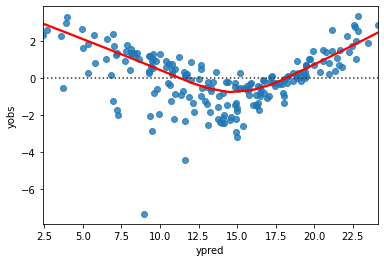

In [38]:
# TODO
sns.residplot( x=mulvis["ypred"], y=mulvis["yobs"], lowess=True, line_kws=dict(color="r") )

This plot is equivalent to:

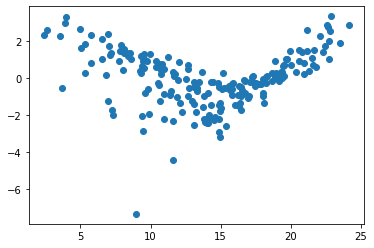

In [39]:
plt.scatter( mulvis.ypred, mulvis.resid )

We also plot the residual plot of the multiple linear regression. Will the residual plot with ```order = 2``` be the same as that of the polynomial regression above?

<AxesSubplot:xlabel='ypred', ylabel='yobs'>

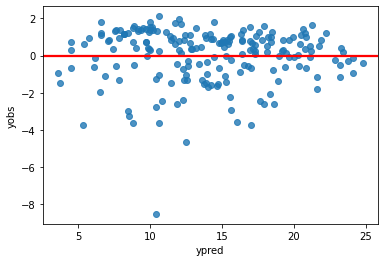

In [40]:
mulvis = get_vis_dataframe( mul_est, X, y )
sns.residplot( x=mulvis["ypred"], y=mulvis["yobs"], lowess=True, order=2, line_kws=dict(color="r") )

This plot is equivalent to:

In [ ]:
values = mulvis.resid - np.polyval( np.polyfit(mulvis.ypred, mulvis.resid, 2), mulvis.ypred )

plt.scatter( mulvis.ypred, values )